### Calculate human use variables
* Calculates summary statistic from point and polygon input features for each variable
* Exports variables as csv file

In [21]:
# Import necessary modules
import numpy as np
import matplotlib.pyplot as plt
import fiona
import geopandas as gp
from geopandas.tools import sjoin
import pandas as pd
from sklearn.preprocessing import PowerTransformer # for data transformations
pd.options.mode.chained_assignment = None  # Supress pandas chained assigment warnings

In [22]:
# Paths to data

# RCAs
rcas = "/mnt/d/Projects/RCA-monitoring/Data/RCA2019/RCA_2019_albers.shp"
rcas_prawncrab = "/mnt/d/Projects/RCA-monitoring/Data/RCA2019/RCA_2019_prawn_crab.shp"
rcas70 = "/mnt/d/Projects/RCA-monitoring/Data/RCA2019/RCA_2019_70km.gdb"

# Population
pop = "/mnt/d/Projects/RCA-monitoring/Data/BC_POP_DATA/fromSelina/BC_MAJOR_CITIES_with_poplndata_2011_2019.shp" #P2016_2019

# Distance to fishing base
floating = "/mnt/d/Projects/RCA-monitoring/Data/floating_infrastructure.gdb"
docks_layer = "docks"
homes_layer = "homes_lodges"

# Coastal infrastructure
coastal = "/mnt/d/Projects/RCA-monitoring/Data/Coastal_Infrastructure.gdb"

# Fisheries
fishing = "/mnt/d/Projects/RCA-monitoring/Data/FisheriesLayers.gdb"
crab = "Crab_EM_RCAs"
prawn = "Prawn_points_RCAs"
trawl = "MidwaterTrawl_lines_RCAs"

In [23]:
# Load RCA polygons
rca_polys = gp.read_file(rcas)

# Load csv with RCA area values for calculating proportion
geo = pd.read_csv("Geographic/georgraphic_variables.csv")

(array([107.,   8.,   2.,   2.,   3.,   1.,   0.,   3.,  24.,  12.]),
 array([      0. ,  323438.2,  646876.4,  970314.6, 1293752.8, 1617191. ,
        1940629.2, 2264067.4, 2587505.6, 2910943.8, 3234382. ]),
 <BarContainer object of 10 artists>)

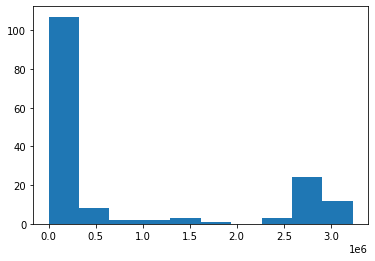

In [24]:
# Nearby population variable

# Load rcas with 70km buffers
rca_70_polys = gp.read_file(rcas70, layer='rca_70km_noland')

# Load population points
pop_points = gp.read_file(pop)

# Spatial join of buffered RCAs and population point data
points_polys = gp.sjoin(rca_70_polys, pop_points, how="left")

# Sum census population (from 2019 or 2016 if missing) within 100km of each RCA
rcadat = points_polys.groupby('NAME_left')['P2016_2019'].agg(['sum']).reset_index()
rcadat.columns = ['Name', 'Population']
plt.hist(rcadat['Population'])

In [26]:
# High population (95%)
rcadat[rcadat.Population > rcadat['Population'].quantile(.95)]

Name  Population
5          Bedwell Harbour   3199122.0
7        Bell Chain Islets   3209403.0
46   Eastern Burrard Inlet   3011209.0
54    Galiano Island North   3220962.0
85      Mayne Island North   3220212.0
93            Navy Channel   3209403.0
111   Prevost Island North   3128990.0
133          South Saturna   3203079.0
144     Trincomali Channel   3234382.0

(array([120.,  21.,   9.,   3.,   5.,   1.,   1.,   1.,   0.,   1.]),
 array([    0.        ,  4041.8831374 ,  8083.76627481, 12125.64941221,
        16167.53254961, 20209.41568702, 24251.29882442, 28293.18196182,
        32335.06509923, 36376.94823663, 40418.83137403]),
 <BarContainer object of 10 artists>)

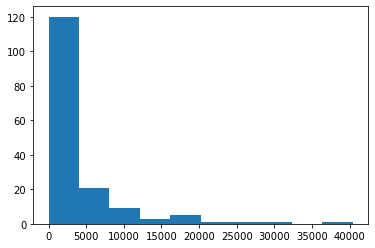

In [27]:
# Distance to nearest fishing base
# Value of zero means the nearest fishing base is within the RCA 

# Load fishing base (docks, homes and lodges) points and combine
b1 = gp.read_file(floating, layer=docks_layer)
b2 = gp.read_file(floating, layer=homes_layer)
bases = b1.geometry.append(b2.geometry).reset_index()
bases.columns = ['index','geometry']

# Calulcate nearest distances
min_distances = []
for p in range(len(rca_polys)):    
    # Get RCA polygon
    poly = rca_polys.iloc[[p]].reset_index()
    # Calcalate distance between RCA and all points (bases)
    tmp = bases.apply(lambda row: poly.distance(row.geometry), axis=1)
    min_distances.append( min(tmp[0]) )  

# Add to rca datadrame
rcadat['Near_Base'] = min_distances
plt.hist(rcadat['Near_Base'])

(array([131.,  18.,   2.,   2.,   4.,   1.,   1.,   0.,   1.,   2.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

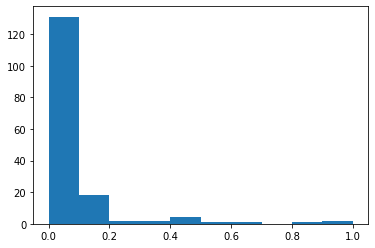

In [28]:
# Amount of coastal infrastructure (non-weighted)
# Sum of all points and polygons within RCAs 
# Not adjusted by area, because coastal not area based

# List coastal infrastructure layers
clayers = fiona.listlayers(coastal)

# Start blank dataframe to fill
df = rcadat.iloc[:,0:1]

# Loop through layers, count number of points or polygons in each RCA
for i in clayers:
   # Load layer
    tmp = gp.read_file(coastal, layer=i)
    # Spatial join
    dfjoin = gp.sjoin(rca_polys, tmp, how='left')
    dfjoin.rename(columns={'NAME_left':'NAME'}, inplace=True)
    # Sum of points within each RCA
    df[ i ] = dfjoin.groupby('NAME')['index_right'].agg(['count']).reset_index()['count']
    
# Create dictionary of weights for infrastructure types
# Get column names
infa = list(df.columns)[1:]
# Create dictionary
infa_dict = { i : 1 for i in infa }
# Adjust weights
infa_dict['docks_rcas'] = 2
infa_dict['homes_lodges_rcas'] = 2
infa_dict['ports_terminals_rcas'] = 2
infa_dict['wastewater_outflows_rcas'] = 3
infa_dict['log_storage_rcas'] = 3
infa_dict['active_aquaculture_rcas'] = 3
infa_dict['dumping_sites_rcas'] = 3
# Columns to update
cols_to_update = list(infa_dict.keys()) 
# Multiply the selected columns
df[cols_to_update] = df[cols_to_update].mul(pd.Series(infa_dict), axis=1)[cols_to_update]

# Sum over all columns (infrastructure types)
infra_sum = np.array( df.iloc[:,1:].agg("sum", axis="columns") )

# Transform to make the probability distribution of a variable more Gaussian
# Stabilizing the variance of the distribution, index from 0 to 1
#power = PowerTransformer(method='yeo-johnson', standardize=False)
#infra_trans = power.fit_transform(infra_sum.reshape(-1, 1))
rcadat['Coast_Infr'] = abs( infra_sum / max(infra_sum) )
plt.hist( rcadat['Coast_Infr'] )

In [30]:
# High coastal infrastructure (95%)
rcadat[rcadat.Coast_Infr > rcadat['Coast_Infr'].quantile(.95)]

Name  Population  Near_Base  Coast_Infr
64                        Hardy Island    225192.0        0.0    0.447552
70         Indian Arm - Crocker Island   2902322.0        0.0    0.937063
71           Indian Arm - Twin Islands   2902322.0        0.0    0.811189
82                           Maple Bay   2697779.0        0.0    0.594406
94                       Nelson Island    223152.0        0.0    1.000000
99   Octopus Islands to Hoskyn Channel     97692.0        0.0    0.629371
111               Prevost Island North   3128990.0        0.0    0.405594
116              Read - Cortes Islands     97692.0        0.0    0.468531
155                           West Bay   2692046.0        0.0    0.489510

(array([161.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([    0.        ,  1413.49816732,  2826.99633463,  4240.49450195,
         5653.99266926,  7067.49083658,  8480.9890039 ,  9894.48717121,
        11307.98533853, 12721.48350584, 14134.98167316]),
 <BarContainer object of 10 artists>)

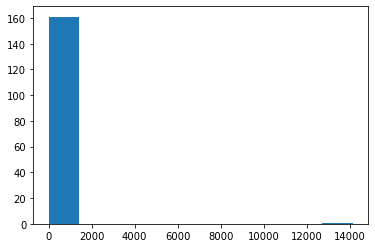

In [31]:
# Midwater trawl fishing pressure
# Sum of the length of fishing lines within RCAs, area adjusted
# Not adjusted with power transformation because of large outlier (Goletas)

#Load trawl data
trawl_lines = gp.read_file(fishing, layer=trawl)

# Calculate the length of the lines
trawl_lines['lines_length'] = trawl_lines.geometry.length

# Spatial join
trawljoin = gp.sjoin(rca_polys, trawl_lines, how='left')

# Sum length of lines by RCA
# Adjust sum values by dividing by area
trawl_sum = trawljoin.groupby('NAME')['lines_length'].agg(['sum']).reset_index()['sum']
rcadat['Trawl_Fish'] = trawl_sum / geo['Area']
plt.hist(rcadat['Trawl_Fish'])

In [32]:
# High trawl fishing pressure (95%)
rcadat[rcadat.Trawl_Fish > rcadat['Trawl_Fish'].quantile(.95)]

Name  Population     Near_Base  Coast_Infr  \
0            Ajax / Achilles Bank    250102.0   6618.549117    0.000000   
10                Bolivar Passage      7919.0   4319.968174    0.000000   
18   Browning Passage - Hunt Rock      7919.0      0.000000    0.041958   
54           Galiano Island North   3220962.0   1361.142456    0.000000   
55                Goletas Channel      7919.0   3073.887130    0.000000   
56                   Goose Island      1019.0  19541.761856    0.000000   
97                 Nowell Channel      7919.0   1171.898967    0.000000   
126                 Scott Islands         0.0  40418.831374    0.000000   
142                       Topknot      4998.0   7006.455684    0.000000   

       Trawl_Fish  
0      181.434103  
10     332.840659  
18     387.013472  
54     117.136715  
55   14134.981673  
56     267.069587  
97     207.563594  
126     78.993306  
142    156.869238

(array([110.,  29.,  13.,   6.,   1.,   2.,   0.,   0.,   0.,   1.]),
 array([   0.        ,  311.41276002,  622.82552004,  934.23828006,
        1245.65104008, 1557.0638001 , 1868.47656012, 2179.88932014,
        2491.30208016, 2802.71484017, 3114.12760019]),
 <BarContainer object of 10 artists>)

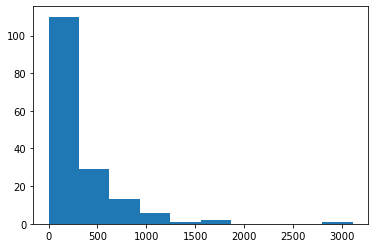

In [33]:
# Bottom contact fishing pressure
# Sum of the fishing event (prawn, 2007 to 2018) or traps (crab, (2011 to 2016)) within RCAs, area adjusted

# Load trap data
crabtrap = gp.read_file(fishing, layer=crab)
prawntrap = gp.read_file(fishing, layer=prawn)

# Spatial join
crabjoin = gp.sjoin(rca_polys, crabtrap, how='left')
prawnjoin = gp.sjoin(rca_polys, prawntrap, how='left')

# Count traps by RCA
# Multiple prawn counts by 50 to represent traps instead of events (on avg there are 50 traps per event)
crabcounts_adj = crabjoin.groupby('NAME')['index_right'].agg(['count']).reset_index()['count'] / 6 / geo['Area'] # divide by 6 years and area
prawncounts_adj = prawnjoin.groupby('NAME')['index_right'].agg(['count']).reset_index()['count'] * 50 / 12 / geo['Area'] # divide by 12 years and area
trap_counts_adj = np.array( crabcounts_adj + prawncounts_adj )

# Add crab and prawn traps to rca polygons
rca_polys = rca_polys.assign(Crab_trap=crabcounts_adj)
rca_polys = rca_polys.assign(Prawn_trap=prawncounts_adj)
rca_polys.to_file(rcas_prawncrab)

# Transform to make the probability distribution of a variable more Gaussian
# Stabilizing the variance of the distribution
# power = PowerTransformer(method='yeo-johnson', standardize=False)
# trap_counts_trans = power.fit_transform(trap_counts_adj.reshape(-1, 1))

# Add to rcadat and plot
rcadat['Traps_Fish'] = trap_counts_adj
plt.hist( rcadat['Traps_Fish'] )

In [34]:
# High traps fishing pressure (95%)
rcadat[rcadat.Traps_Fish > rcadat['Traps_Fish'].quantile(.95)]

Name  Population    Near_Base  Coast_Infr  Trawl_Fish  \
27             Coal Island   2487038.0     0.000000    0.209790         0.0   
28            Coffin Point   2707840.0     0.000000    0.055944         0.0   
46   Eastern Burrard Inlet   3011209.0     0.000000    0.104895         0.0   
105         Passage Island   2847012.0  2161.857241    0.000000         0.0   
106             Patey Rock   1569768.0  1122.243504    0.000000         0.0   
109         Port Elizabeth      7578.0  6197.402230    0.020979         0.0   
137           Teakerne Arm     97350.0     0.000000    0.055944         0.0   
138   Thetis-Kuper Islands   2910651.0     0.000000    0.377622         0.0   
140       Thormanby Island   1008820.0     0.000000    0.153846         0.0   

      Traps_Fish  
27   1615.918904  
28   1085.699412  
46   3114.127600  
105  1133.672277  
106  1611.328169  
109  1456.434249  
137   969.561679  
138  1074.916585  
140  1067.869156

In [35]:
# Export to file
rcadat.to_csv('HumanUse/human_variables.csv')
rcadat

Name  Population     Near_Base  Coast_Infr  \
0               Ajax / Achilles Bank    250102.0   6618.549117    0.000000   
1                    Ballenas Island    281414.0   4025.985043    0.000000   
2            Bate - Shadwell Passage      7919.0      0.000000    0.013986   
3          Baynes Sound - Ship Point    138687.0    201.344528    0.000000   
4                    Becher Bay East    428609.0   1034.622067    0.000000   
..                               ...         ...           ...         ...   
157  West Cracroft Island - Boat Bay      7578.0   2702.129860    0.000000   
158                   West Vancouver   2847012.0  18036.903555    0.069930   
159                West of Bajo Reef      1719.0      0.000000    0.000000   
160                  Weynton Passage      8261.0   1945.131746    0.000000   
161                 Woolridge Island   2643301.0      0.000000    0.055944   

     Trawl_Fish  Traps_Fish  
0    181.434103  293.782654  
1      0.000000  717.154307  
2      0.000000    0.337600  
3      0.000000  481.717767  
4      0.000000   13.061260  
..          ...         ...  
157    0.000000    3.710599  
158    0.000000   35.000958  
159    0.000000    0.000000  
160    0.000000    0.530488  
161    0.000000  132.915081  

[162 rows x 6 columns]

array([[ 1.        , -0.26888182],
       [-0.26888182,  1.        ]])

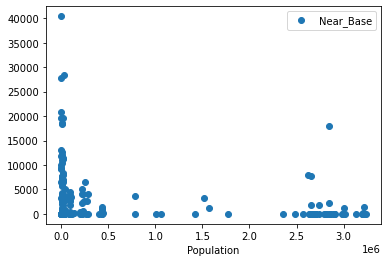

In [36]:
# Check for correlations 
rcadat.plot(x='Population', y='Near_Base', style='o')
np.corrcoef(rcadat['Population'], rcadat['Near_Base'])

<AxesSubplot:xlabel='Coast_Infr'>

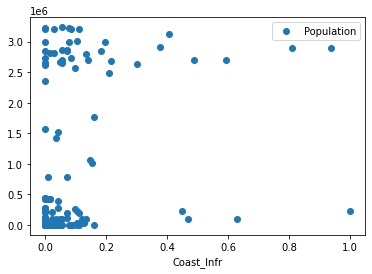

In [37]:
# Check for correlations 
rcadat.plot(x='Coast_Infr', y='Population', style='o')

<AxesSubplot:xlabel='Trawl_Fish'>

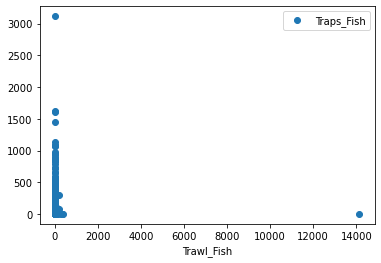

In [38]:
# Check for correlations 
rcadat.plot(x='Trawl_Fish', y='Traps_Fish', style='o')